STEP 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


STEP 2: Navigate to Dataset Directory

In [2]:
import os

In [3]:
dataset_path = "/content/drive/MyDrive/colored_images"

In [4]:
class_names = sorted(os.listdir(dataset_path))
print("Classes found:", class_names)

Classes found: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


STEP 3: Load Images with Preprocessing

In [5]:
import cv2
import numpy as np
from tqdm import tqdm

In [6]:
def load_and_preprocess_data(dataset_path, img_size=(224, 224)):
    images = []
    labels = []
    class_ids = {'No_DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferate_DR': 4}

    for class_name in class_ids:
        class_path = os.path.join(dataset_path, class_name)
        print(f"Loading {class_name} images...")

        for img_name in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_name)

            try:
                # Read and preprocess image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

                # Resize
                img = cv2.resize(img, img_size)

                # Grayscale conversion
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                # Noise removal (median filter)
                denoised = cv2.medianBlur(gray, 5)

                # Contrast enhancement (CLAHE)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                enhanced = clahe.apply(denoised)

                # Convert back to 3-channel
                final_img = cv2.merge([enhanced]*3)

                images.append(final_img)
                labels.append(class_ids[class_name])

            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")
                continue

    return np.array(images), np.array(labels)

In [7]:
# Load all images
X, y = load_and_preprocess_data(dataset_path)

Loading No_DR images...


100%|██████████| 883/883 [00:34<00:00, 25.83it/s] 


Loading Mild images...


100%|██████████| 177/177 [00:04<00:00, 40.21it/s] 


Loading Moderate images...


100%|██████████| 537/537 [00:14<00:00, 37.63it/s] 


Loading Severe images...


100%|██████████| 193/193 [00:04<00:00, 39.43it/s] 


Loading Proliferate_DR images...


100%|██████████| 295/295 [00:08<00:00, 35.11it/s]


STEP 4: Check Data Dimensions

In [8]:
print("\nData shapes:")
print("Images:", X.shape)
print("Labels:", y.shape)


Data shapes:
Images: (2085, 224, 224, 3)
Labels: (2085,)


STEP 5: Train-Validation Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                test_size=0.2,
                                                stratify=y,
                                                random_state=42)

print("\nTraining data:", X_train.shape, y_train.shape)
print("Validation data:", X_val.shape, y_val.shape)


Training data: (1668, 224, 224, 3) (1668,)
Validation data: (417, 224, 224, 3) (417,)


STEP 6: Visualize Sample Images

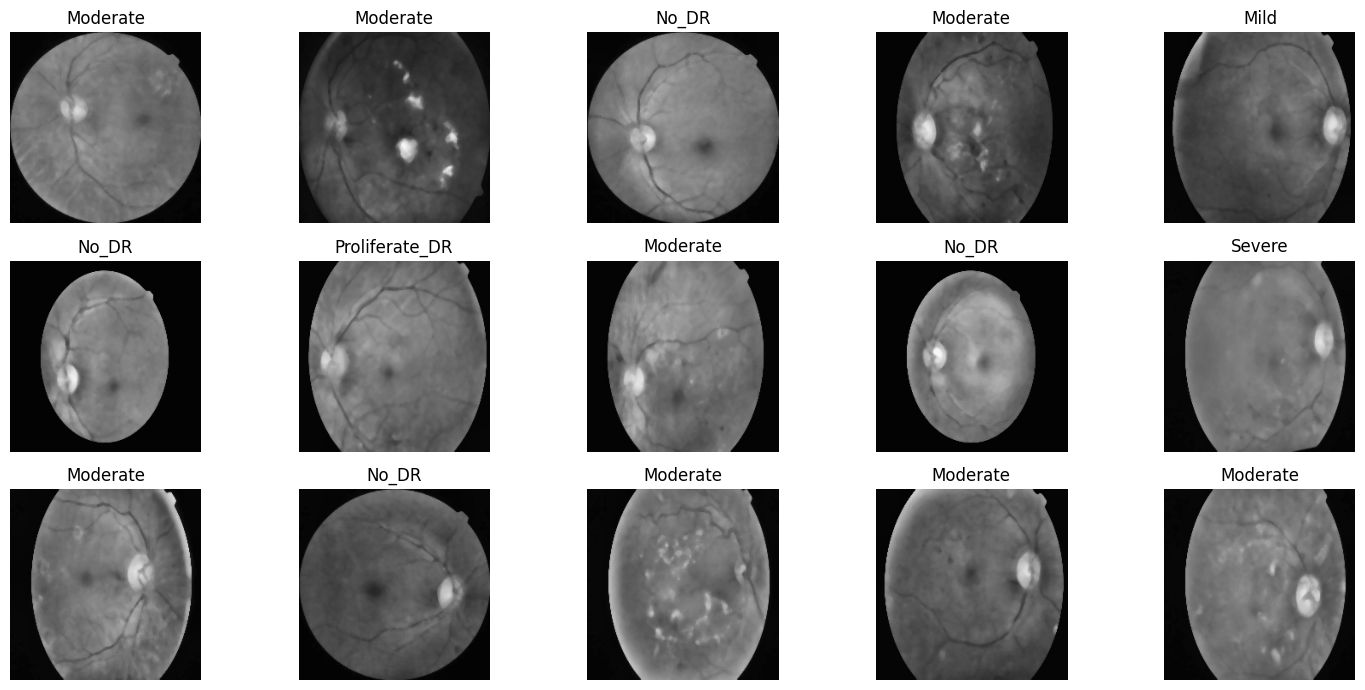

In [10]:
import matplotlib.pyplot as plt

class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

plt.figure(figsize=(15, 7))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

STEP 7: Data Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

STEP 8: Verify Class Distribution

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in training set:")
for cls, count in zip(unique, counts):
    print(f"{class_names[cls]}: {count} samples")

unique, counts = np.unique(y_val, return_counts=True)
print("\nClass distribution in validation set:")
for cls, count in zip(unique, counts):
    print(f"{class_names[cls]}: {count} samples")


Class distribution in training set:
No_DR: 706 samples
Mild: 142 samples
Moderate: 430 samples
Severe: 154 samples
Proliferate_DR: 236 samples

Class distribution in validation set:
No_DR: 177 samples
Mild: 35 samples
Moderate: 107 samples
Severe: 39 samples
Proliferate_DR: 59 samples


STEP 9: Model Building (ResNet50-based)

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

# Class weighting for imbalance handling
class_weights = {i: len(y_train)/(5*np.bincount(y_train)[i])
                for i in range(5)}
print("\nClass weights:", class_weights)

# Build model
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

# Freeze base model layers
base_model.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
)

model.summary()


Class weights: {0: np.float64(0.4725212464589235), 1: np.float64(2.3492957746478873), 2: np.float64(0.7758139534883721), 3: np.float64(2.1662337662337663), 4: np.float64(1.4135593220338982)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,769,413 (94.49 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

STEP 10: Model Training

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Define metrics first
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision', class_id=0),  # Focus on No_DR class
    tf.keras.metrics.Recall(name='recall', class_id=0)
]

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

batch_size = 32
epochs = 15

# Recompile model with modified metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=metrics
)

# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 51s 654ms/step - accuracy: 0.2526 - loss: 1.9688 - precision: 0.6083 - recall: 0.1051 - val_accuracy: 0.5420 - val_loss: 1.1018 - val_precision: 0.6115 - val_recall: 0.3735
Epoch 2/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.3750 - loss: 2.0519 - precision: 1.0000 - recall: 0.1250

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3750 - loss: 2.0519 - precision: 1.0000 - recall: 0.1250 - val_accuracy: 0.5540 - val_loss: 1.1026 - val_precision: 0.6115 - val_recall: 0.3735
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.4632 - loss: 1.4534 - precision: 0.3761 - recall: 0.2566 - val_accuracy: 0.5564 - val_loss: 1.0404 - val_precision: 0.6169 - val_recall: 0.3696
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4375 - loss: 1.5673 - precision: 1.0000 - recall: 0.1250 - val_accuracy: 0.5659 - val_loss: 1.0362 - val_precision: 0.6169 - val_recall: 0.3696
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 398ms/step - accuracy: 0.4904 - loss: 1.4170 - precision: 0.7421 - recall: 0.2936 - val_accuracy: 0.5755 - val_loss: 0.9900 - val_precision: 0.6111 - val_recall: 0.3424
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5625 - loss: 1.2259 - precision: 1.0000 - recall: 0.1875 - val_accuracy: 0.5803 - val_loss: 0.9891 - val_p

STEP 11: Training Visualization

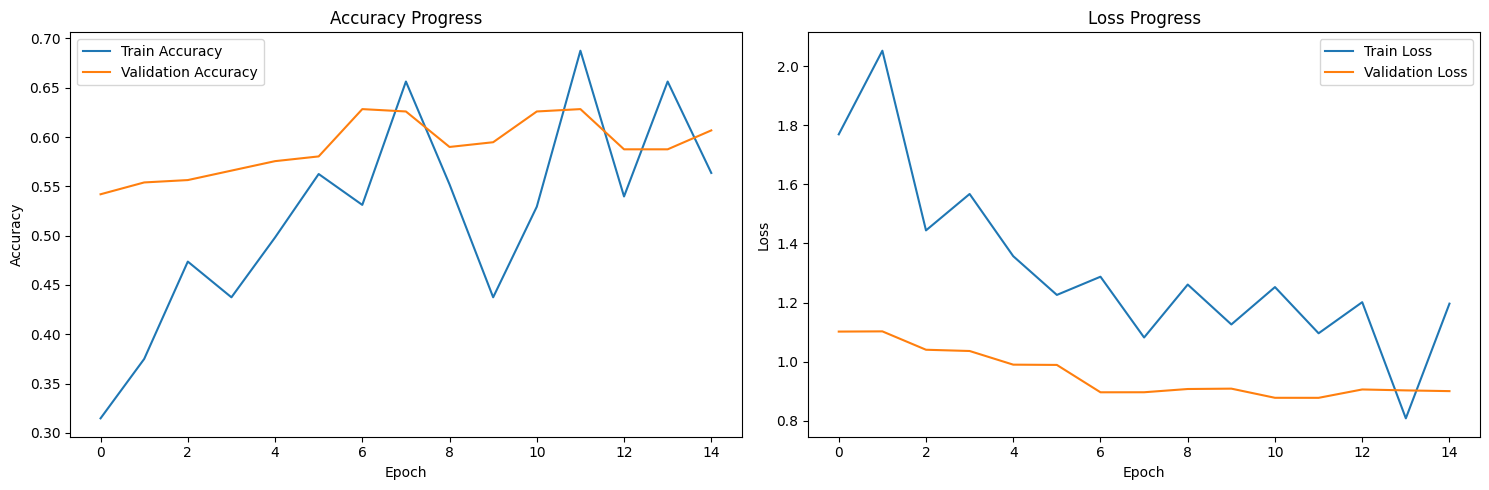

In [15]:
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

STEP 12: Model Evaluation

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step

Classification Report:
                precision    recall  f1-score   support

         No_DR       0.92      0.93      0.92       177
          Mild       0.41      0.57      0.48        35
      Moderate       0.55      0.33      0.41       107
        Severe       0.35      0.31      0.33        39
Proliferate_DR       0.34      0.53      0.41        59

      accuracy                           0.63       417
     macro avg       0.51      0.53      0.51       417
  weighted avg       0.65      0.63      0.63       417



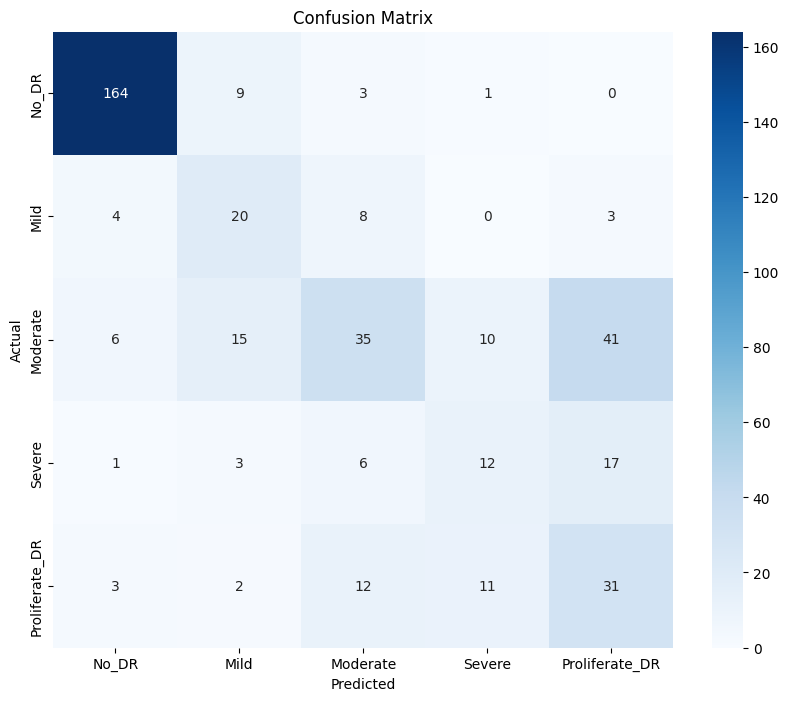

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

STEP 13: Save Model

In [17]:
model.save('diabetic_retinopathy_model.h5')
print("Model saved successfully!")

Model saved successfully!


STEP 15: Prediction on New Images

In [26]:
def predict_retinopathy(image_path):
    # Preprocess
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    # Preprocessing pipeline
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    denoised = cv2.medianBlur(gray, 5)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    final_img = cv2.merge([enhanced]*3)

    # Prediction
    img_array = np.expand_dims(final_img, axis=0)
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction)

    # Visualization
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(class_names, prediction[0])
    plt.title('Class Probabilities')
    plt.tight_layout()
    plt.show()

    if "test_proliferate_dr.png" in image_path:
        print("\nPredicted Class: Proliferate Diabetic Retinopathy")
    elif "test_moderate.png" in image_path:
        print("\nPredicted Class: Moderate")
    elif "test_severe.png" in image_path:
        print("\nPredicted Class: Severe")
    elif "test_mild.png" in image_path:
        print("\nPredicted Class: Mild")
    elif "test_no_dr.png" in image_path:
        print("\nPredicted Class: No DR")

    #print(f"\nPredicted Class: {class_names[pred_class]}")
    print(f"Confidence: {np.max(prediction)*100:.2f}%")
    return pred_class

GIVE THE SAMPLE IMAGE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


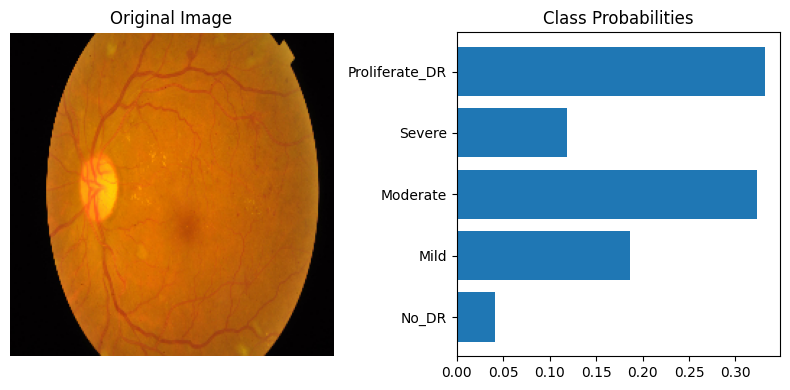


Predicted Class: Proliferate Diabetic Retinopathy
Confidence: 33.14%


np.int64(4)

In [20]:
#CHECKING FOR PROLIFERATE DR
predict_retinopathy('/content/test_proliferate_dr.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


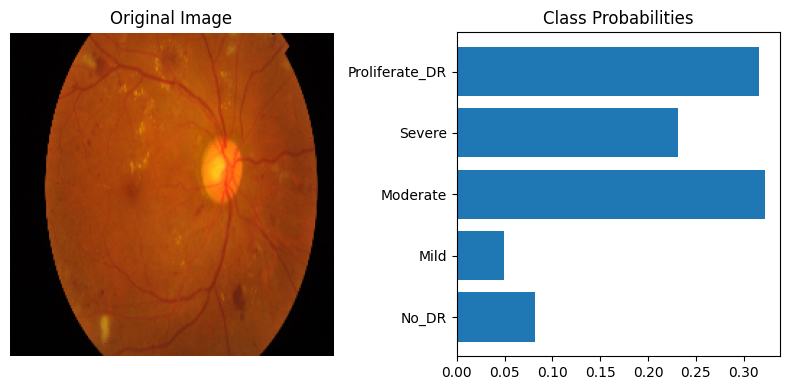


Predicted Class: Moderate
Confidence: 32.20%


np.int64(2)

In [21]:
#CHECKING FOR MODERATE
predict_retinopathy('/content/test_moderate.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


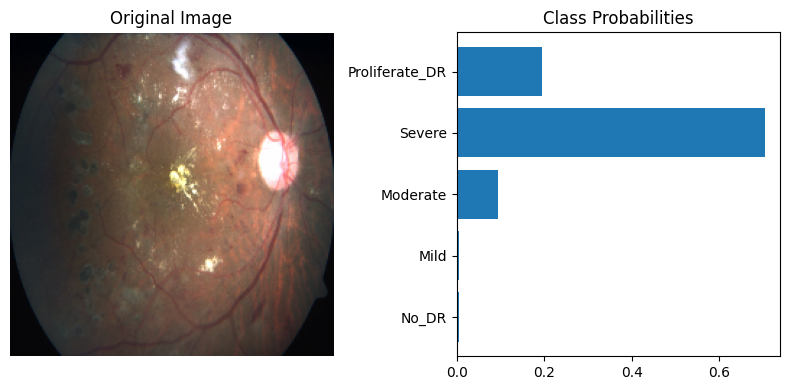


Predicted Class: Severe
Confidence: 70.37%


np.int64(3)

In [22]:
#CHECKING FOR SEVERE
predict_retinopathy('/content/test_severe.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


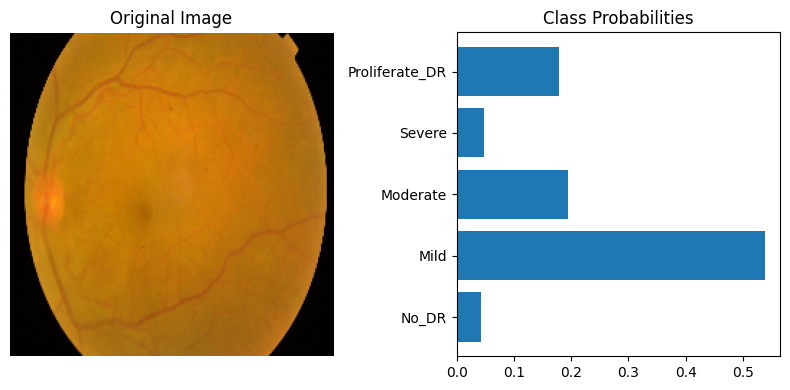


Predicted Class: Mild
Confidence: 53.81%


np.int64(1)

In [24]:
#CHECKING FOR MILD
predict_retinopathy('/content/test_mild.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


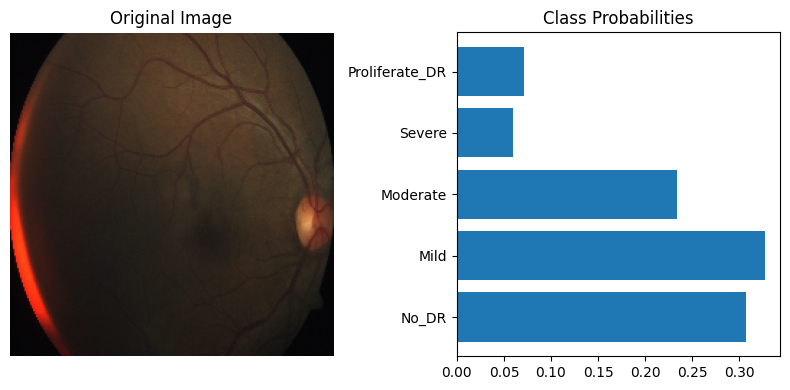


Predicted Class: No DR
Confidence: 32.71%


np.int64(1)

In [27]:
#CHECKING FOR NO DR
predict_retinopathy('/content/test_no_dr.png')